In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [7]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [9]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [10]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, inp, dp=0.5, edp=0.1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(1e-4*torch.randn(nTgts,inp.shape[-1],2).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.active.shape[0]):
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss, avg.detach().cpu().numpy()

for grp in range(1,2):
    trainIdcs = groups[grp][0][0:496]
    validIdcs = groups[grp][0]
    testIdcs = groups[grp][1]

#     X0 = nback_p_t[:,rnback[grp]]
#     X1 = emoid_p_t[:,remoid[grp]]
    X0 = nback_p_t
    X1 = emoid_p_t
    Xreg = torch.stack([X0,X1], dim=1)

    nEpochs = 1000
    pPeriod = 20
    thresh = 20

    sim = LatSim(2, Xreg, 0.5, 0.1) # 0.2 wrat, 0.1 other
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

    Xt = Xreg[trainIdcs]
    Xv = Xreg[validIdcs]

    trainLoss = []
    validLoss = []

    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])

    var = age_t

    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = 0
        for r in res + [avg]:
            loss += mseLoss(r, var[trainIdcs])
        loss = torch.stack([loss/(len(res)+1)])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss))}')
            lossV, _ = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break

    print('Finished training')

    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss, avg = validate(sim, Xreg, var, testIdcs)
    rmse.append(loss)
    
#     yhat[testIdcs] = avg[testIdcs]
    print(f'FINISHED {grp} {loss}')

epoch 0 loss=1470.6141357421875
New best validation epoch 0 loss=40.03742599487305
epoch 20 loss=790.5079956054688
New best validation epoch 20 loss=29.622909545898438
epoch 40 loss=218.10336303710938
New best validation epoch 40 loss=25.569826126098633
epoch 60 loss=101.09837341308594
New best validation epoch 60 loss=23.989269256591797
epoch 80 loss=59.907554626464844
epoch 100 loss=57.96455001831055
epoch 120 loss=49.79548263549805
epoch 140 loss=44.03058624267578
New best validation epoch 140 loss=23.91346549987793
epoch 160 loss=46.81063461303711
epoch 180 loss=35.546302795410156
epoch 200 loss=39.44725799560547
New best validation epoch 200 loss=23.344472885131836
epoch 220 loss=31.732519149780273
epoch 240 loss=32.885196685791016
epoch 260 loss=41.45411682128906
epoch 280 loss=33.49406051635742
New best validation epoch 280 loss=22.926315307617188
epoch 300 loss=31.925514221191406
epoch 320 loss=31.578323364257812
epoch 340 loss=23.52676010131836
epoch 360 loss=24.30564498901367

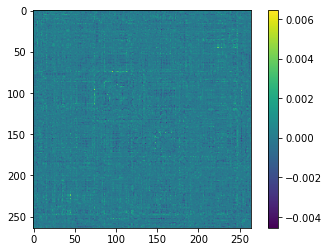

In [11]:
import matplotlib.pyplot as plt

def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

# nback/emoid, weights, latDim
z = sim.active[0,:,0].unsqueeze(0).detach()*nback_p_t

plt.imshow(heatmap(z[0]))
plt.colorbar()

plt.show()

In [16]:
lst = torch.argsort(z[0]**2)[-10:].cpu().numpy()

In [17]:
a = np.triu_indices(264,1)[0][lst]
b = np.triu_indices(264,1)[1][lst]

print(np.stack([a,b]))

[[  4  35 177  82 121  74  10 147  86  45]
 [184 229 197 148 224 110  52 154 183 245]]


In [20]:
sim.active[0,lst[0],0]

tensor(0.0026, device='cuda:0', grad_fn=<SelectBackward0>)

In [12]:
ageGenIdcs = {  
    'young_m': [],
    'young_f': [],
    'middle_m': [],
    'middle_f': [],
    'old_m': [],
    'old_f': []
}

for i in range(age.shape[0]):
    a = age[i]
    g = gen[i,0]
    if a <= 11*12:
        if g == 0:
            ageGenIdcs['young_f'].append(i)
        else: 
            ageGenIdcs['young_m'].append(i)
    elif a >= 13*12 and a <= 15*12:
        if g == 0:
            ageGenIdcs['middle_f'].append(i)
        else: 
            ageGenIdcs['middle_m'].append(i)
    elif a >= 18*12:
        if g == 0:
            ageGenIdcs['old_f'].append(i)
        else: 
            ageGenIdcs['old_m'].append(i)

print('Complete')

Complete


In [13]:
ageGenIdcsComb = {
    'young': ageGenIdcs['young_m'] + ageGenIdcs['young_f'],
    'middle': ageGenIdcs['middle_m'] + ageGenIdcs['middle_f'],
    'old': ageGenIdcs['old_m'] + ageGenIdcs['old_f']
}

print('Complete')

Complete


In [15]:
def difGroups(g1, g2, x, w, idcs):
    others = [g for g in idcs.keys() if g != g1 and g != g2]
    gs = [g1, g2] + others
    p = len(gs)*[None]
    s = len(gs)*[None]
    for i,g in enumerate(gs):
        x1 = x[idcs[g]]
        p[i] = w.unsqueeze(0)*x1.unsqueeze(2)
        p[i] = torch.mean(p[i], dim=0)
        s[i] = torch.sign(torch.sum(p[i], dim=0))
#         print((torch.sum(s[i] < 0), torch.sum(s[i] > 0)))
    pOther = torch.stack([p[0]*po for po in p[2:]], dim=0)
    pOther = torch.max(pOther, dim=0)[0]
    res = (p[0]*p[1]-pOther)*(p[0]>0)
    idcs = torch.argsort(res, dim=0)[-10:,:]
    print(res[idcs[:,0],0])
    print(res[idcs[:,1],1])
    print(torch.max(p[0]*p[0]))
    print(idcs.T)
    
difGroups('young', 'old', nback_p_t, sim.active[0].detach(), ageGenIdcsComb)

tensor([1.1851e-07, 1.2687e-07, 1.2935e-07, 1.3026e-07, 1.4970e-07, 1.5363e-07,
        1.5656e-07, 2.0601e-07, 2.1777e-07, 2.7880e-07], device='cuda:0')
tensor([3.9119e-08, 4.0250e-08, 4.1415e-08, 4.1797e-08, 4.2896e-08, 4.7172e-08,
        5.3198e-08, 6.0661e-08, 6.6099e-08, 7.5969e-08], device='cuda:0')
tensor(6.4349e-06, device='cuda:0')
tensor([[ 9995, 12442, 11820, 16800, 16776, 29771, 16795, 16773, 12463, 16782],
        [30614, 12447, 16782,  7810,  9186, 29558, 16773, 30244, 12463, 11820]],
       device='cuda:0')
